In [1]:
!pip install bert-for-tf2

In [2]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
import pandas as pd
import numpy as np
import re
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [3]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [4]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
data = pd.read_csv("./dataset/dataset.csv")
print(data.head())

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


In [6]:
newData=[]
labels=[]
for i,element in enumerate(data.posts):
    temp = element.split("|||")
    for post in temp:
        newData.append(post)
        labels.append(data.type[i])

In [7]:
print(len(newData))
print(len(labels))
print(newData[25])
print(labels[25])

422845
422845
Get high in backyard, roast and eat marshmellows in backyard while conversing over something intellectual, followed by massages and kisses.
INFJ


In [8]:
df=pd.DataFrame()
list_of_tuples = list(zip(newData, labels)) 
df = pd.DataFrame(list_of_tuples, columns = ['sentence', 'type'])  
df.tail()

,sentence,type
422840,I was going to close my facebook a few months ...,INFP
422841,30 Seconds to Mars - All of my collections. It...,INFP
422842,"I have seen it, and i agree. I did actually th...",INFP
422843,Ok so i have just watched Underworld 4 (Awaken...,INFP
422844,I would never want to turn off my emotions. so...,INFP


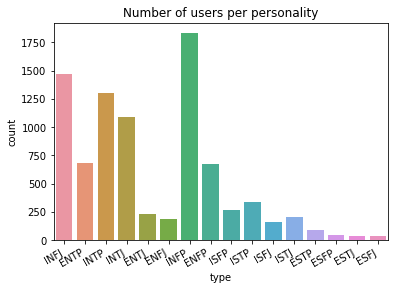

In [9]:
chart = sns.countplot(data.type)
plt.title("Number of users per personality")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [10]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

In [11]:
# We want to remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = unique_type_list + [x.lower() for x in unique_type_list]
# Preprocess data
def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 50000 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments using regular expressions
        posts = row[1].sentence
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp)
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")
        type_labelized = translate_personality(row[1].type)
        if (temp!="") and (temp!=" "):
            list_personality.append(type_labelized)
            temp="[CLS]"+temp+"[SEP]"
            list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [12]:
list_posts, list_personality  = pre_process_data(df, remove_stop_words=True)

1 of 422845 rows
50000 of 422845 rows
100000 of 422845 rows
150000 of 422845 rows
200000 of 422845 rows
250000 of 422845 rows
300000 of 422845 rows
350000 of 422845 rows
400000 of 422845 rows
422845 of 422845 rows


In [13]:
X=list_posts
Y=list_personality
print(len(X))
print(len(Y))
print(X[0])
print(Y[0])

408623
408623
[CLS] and  moments sportscenter not top ten plays pranks[SEP]
[0 0 0 0]


In [14]:
# importing the tokenizer and testing it
tokenizer = FullTokenizer(
  vocab_file="./dataset/bert/vocab.txt"
)
tokens=tokenizer.tokenize("I'm here to stay , hello nice to meet you sir")
tokens=["[CLS]"]+tokens+["[SEP]"]
print(tokens)
indices=tokenizer.convert_tokens_to_ids(tokens)
print(indices)

['[CLS]', 'i', "'", 'm', 'here', 'to', 'stay', ',', 'hello', 'nice', 'to', 'meet', 'you', 'sir', '[SEP]']
[101, 1045, 1005, 1049, 2182, 2000, 2994, 1010, 7592, 3835, 2000, 3113, 2017, 2909, 102]


In [15]:
# Tokenizing the features
def tokenize_features(X):
    X_tokenized=[]
    for i,entry in enumerate(X):
        if (i % 50000 == 0 or i == 1 or i == len(X)):
            print("%s of %s rows" % (i, len(X)))
        temp=[]
        temp=tokenizer.tokenize(entry)
        temp = [w.replace('|', '[SEP]') for w in temp]
        if temp[0] == "[SEP]":
            temp.pop(0)
        temp.insert(0,"[CLS]")
        temp.append("[SEP]")
        X_tokenized.append(temp)
    return(X_tokenized)

X_tokenized=tokenize_features(X)

0 of 408623 rows
1 of 408623 rows
50000 of 408623 rows
100000 of 408623 rows
150000 of 408623 rows
200000 of 408623 rows
250000 of 408623 rows
300000 of 408623 rows
350000 of 408623 rows
400000 of 408623 rows


In [16]:
# indexing the tokens
def tokens_to_indices(tokens):
    result = []
    for element in tokens:
        indices =[]
        indices=tokenizer.convert_tokens_to_ids(element)
        result.append(indices)
    return result
X_indexed=tokens_to_indices(X_tokenized)
print(X_indexed[0])

[101, 1031, 18856, 2015, 1033, 1998, 5312, 2998, 13013, 2121, 2025, 2327, 2702, 3248, 26418, 2015, 1031, 19802, 1033, 102]


In [17]:
# getting the longest indexed array
def max_post_words(posts):
    maxLen=0
    averageLen=0
    for post in posts:
        averageLen=averageLen+len(post)
        if maxLen < len(post):
            maxLen=len(post)
    averageLen=int(averageLen/len(posts))
    return maxLen,averageLen
maxLen,avgLen=max_post_words(X_indexed)
print(maxLen)
print(avgLen)

203
38


In [18]:
# adding padding 
def padding(indices):
    for i,element in enumerate(indices):
        pad=maxLen-len(element)
        l = [0] * pad
        indices[i]=indices[i] + l
    return(indices)
X=np.array(padding(X_indexed))
Y=(np.array(list_personality[:,0])).astype(np.float32)
#Y=(np.array(list_personality)).astype(np.float32)
# Not enough memory to train model with maxLen input size so i'll take the first 512
#X=X[:,:512]

In [19]:
def create_model():    
    with tf.io.gfile.GFile("./dataset/bert/bert_config.json", "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
    input_ids = keras.layers.Input(shape=(maxLen,), dtype='int16', name="input_ids")
    bert_output = bert(input_ids)
    print("bert shape", bert_output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    X1 = keras.layers.Dense(units=1,name="I/E_classifier", activation="sigmoid")(logits)
    '''X2 = keras.layers.Dense(units=1,name="N/S_classifier", activation="sigmoid")(logits)
    X3 = keras.layers.Dense(units=1,name="F/T_classifier", activation="sigmoid")(logits)
    X4 = keras.layers.Dense(units=1,name="J/P_classifier", activation="sigmoid")(logits)
    finalOutput=keras.layers.concatenate(
    inputs=[X1,X2,X3,X4],
    name='final_output')'''
    model = keras.Model(inputs=input_ids, outputs=X1)
    model.build(input_shape=(None, maxLen))
    load_stock_weights(bert, "./dataset/bert/bert_model.ckpt")
    model.layers[1].trainable = False
    return model

In [20]:
bertModel = create_model()
bertModel.summary()

bert shape (None, 203, 768)
loader: Skipping weight:[bert/embeddings/position_embeddings/embeddings:0] as the weight shape:[(1083, 768)] is not compatible with the checkpoint:[bert/embeddings/position_embeddings] shape:(512, 768)
Done loading 195 BERT weights from: ./dataset/bert/bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000016709C5A860> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [1]
Unused weights from checkpoint: 
	bert/embeddings/position_embeddings
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)            

In [21]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
def multi_loss(y_true,y_pred):
    return K.mean(K.sum(K.binary_crossentropy(y_true,y_pred)))

In [ ]:
# Defining hyperparameters
EPOCHS = 5
BS = 32
LR=1e-5
# Compiling and training
bertModel.compile(
  optimizer=keras.optimizers.Adam(LR),
  loss="binary_crossentropy",
  metrics=["accuracy",f1]
)
print(X.shape)
print(Y.shape)
(X_train, X_temp, Y_train, Y_temp) = train_test_split(X,Y,test_size=0.2, random_state=42)
(X_valid, X_test, Y_valid, Y_test) = train_test_split(X_temp,Y_temp,test_size=0.5, random_state=42)
history = bertModel.fit(
  X_train, 
  Y_train,
  validation_data=(X_valid,Y_valid),
  batch_size=BS,
  shuffle=True,
  epochs=EPOCHS,
  verbose=1
)

(408623, 203)
(408623,)
Train on 326898 samples, validate on 40862 samples
Epoch 1/5


  4320/326898 [..............................] - ETA: 27:44:45 - loss: 0.6942 - accuracy: 0.6562 - f1: 0.0000e+0 - ETA: 15:50:38 - loss: 0.7349 - accuracy: 0.6094 - f1: 0.2083    - ETA: 11:52:09 - loss: 0.6992 - accuracy: 0.5938 - f1: 0.213 - ETA: 9:52:09 - loss: 0.7030 - accuracy: 0.6094 - f1: 0.198 - ETA: 8:42:07 - loss: 0.6919 - accuracy: 0.6000 - f1: 0.18 - ETA: 7:54:39 - loss: 0.6952 - accuracy: 0.5885 - f1: 0.18 - ETA: 7:20:37 - loss: 0.7031 - accuracy: 0.5759 - f1: 0.17 - ETA: 6:55:04 - loss: 0.6987 - accuracy: 0.5820 - f1: 0.17 - ETA: 6:35:14 - loss: 0.7097 - accuracy: 0.5799 - f1: 0.16 - ETA: 6:19:11 - loss: 0.7079 - accuracy: 0.5844 - f1: 0.17 - ETA: 6:05:48 - loss: 0.6999 - accuracy: 0.5852 - f1: 0.15 - ETA: 5:54:37 - loss: 0.6876 - accuracy: 0.5990 - f1: 0.17 - ETA: 5:45:25 - loss: 0.6866 - accuracy: 0.6082 - f1: 0.19 - ETA: 5:38:37 - loss: 0.6893 - accuracy: 0.6071 - f1: 0.19 - ETA: 5:31:31 - loss: 0.7042 - accuracy: 0.5938 - f1: 0.17 - ETA: 5:25:17 - loss: 0.6989 - accura

  8672/326898 [..............................] - ETA: 4:03:37 - loss: 0.6134 - accuracy: 0.7132 - f1: 0.09 - ETA: 4:03:28 - loss: 0.6124 - accuracy: 0.7140 - f1: 0.09 - ETA: 4:03:19 - loss: 0.6116 - accuracy: 0.7149 - f1: 0.10 - ETA: 4:03:11 - loss: 0.6106 - accuracy: 0.7154 - f1: 0.10 - ETA: 4:03:06 - loss: 0.6098 - accuracy: 0.7161 - f1: 0.10 - ETA: 4:03:00 - loss: 0.6092 - accuracy: 0.7168 - f1: 0.09 - ETA: 4:02:53 - loss: 0.6093 - accuracy: 0.7172 - f1: 0.09 - ETA: 4:02:46 - loss: 0.6092 - accuracy: 0.7177 - f1: 0.09 - ETA: 4:02:39 - loss: 0.6096 - accuracy: 0.7179 - f1: 0.09 - ETA: 4:02:32 - loss: 0.6117 - accuracy: 0.7172 - f1: 0.09 - ETA: 4:02:25 - loss: 0.6126 - accuracy: 0.7173 - f1: 0.09 - ETA: 4:02:18 - loss: 0.6125 - accuracy: 0.7173 - f1: 0.09 - ETA: 4:02:12 - loss: 0.6115 - accuracy: 0.7179 - f1: 0.09 - ETA: 4:02:06 - loss: 0.6120 - accuracy: 0.7175 - f1: 0.09 - ETA: 4:02:00 - loss: 0.6124 - accuracy: 0.7181 - f1: 0.09 - ETA: 4:01:54 - loss: 0.6118 - accuracy: 0.7188 - f1

 13024/326898 [>.............................] - ETA: 3:53:48 - loss: 0.6125 - accuracy: 0.7241 - f1: 0.08 - ETA: 3:53:46 - loss: 0.6120 - accuracy: 0.7246 - f1: 0.08 - ETA: 3:53:43 - loss: 0.6112 - accuracy: 0.7250 - f1: 0.09 - ETA: 3:53:40 - loss: 0.6113 - accuracy: 0.7248 - f1: 0.09 - ETA: 3:53:37 - loss: 0.6111 - accuracy: 0.7248 - f1: 0.09 - ETA: 3:53:34 - loss: 0.6105 - accuracy: 0.7251 - f1: 0.09 - ETA: 3:53:31 - loss: 0.6100 - accuracy: 0.7255 - f1: 0.08 - ETA: 3:53:28 - loss: 0.6095 - accuracy: 0.7259 - f1: 0.08 - ETA: 3:53:25 - loss: 0.6092 - accuracy: 0.7260 - f1: 0.08 - ETA: 3:53:22 - loss: 0.6096 - accuracy: 0.7255 - f1: 0.08 - ETA: 3:53:19 - loss: 0.6101 - accuracy: 0.7253 - f1: 0.08 - ETA: 3:53:16 - loss: 0.6099 - accuracy: 0.7255 - f1: 0.09 - ETA: 3:53:13 - loss: 0.6105 - accuracy: 0.7252 - f1: 0.09 - ETA: 3:53:11 - loss: 0.6102 - accuracy: 0.7253 - f1: 0.08 - ETA: 3:53:08 - loss: 0.6101 - accuracy: 0.7254 - f1: 0.08 - ETA: 3:53:05 - loss: 0.6101 - accuracy: 0.7256 - f1

 17376/326898 [>.............................] - ETA: 3:48:15 - loss: 0.6109 - accuracy: 0.7258 - f1: 0.09 - ETA: 3:48:13 - loss: 0.6108 - accuracy: 0.7259 - f1: 0.09 - ETA: 3:48:11 - loss: 0.6110 - accuracy: 0.7258 - f1: 0.09 - ETA: 3:48:09 - loss: 0.6113 - accuracy: 0.7257 - f1: 0.09 - ETA: 3:48:07 - loss: 0.6113 - accuracy: 0.7259 - f1: 0.09 - ETA: 3:48:05 - loss: 0.6106 - accuracy: 0.7263 - f1: 0.09 - ETA: 3:48:03 - loss: 0.6108 - accuracy: 0.7259 - f1: 0.09 - ETA: 3:48:00 - loss: 0.6105 - accuracy: 0.7261 - f1: 0.09 - ETA: 3:47:58 - loss: 0.6107 - accuracy: 0.7261 - f1: 0.09 - ETA: 3:47:56 - loss: 0.6111 - accuracy: 0.7259 - f1: 0.09 - ETA: 3:47:54 - loss: 0.6115 - accuracy: 0.7255 - f1: 0.09 - ETA: 3:47:52 - loss: 0.6115 - accuracy: 0.7255 - f1: 0.09 - ETA: 3:47:50 - loss: 0.6114 - accuracy: 0.7254 - f1: 0.09 - ETA: 3:47:48 - loss: 0.6110 - accuracy: 0.7258 - f1: 0.09 - ETA: 3:47:46 - loss: 0.6103 - accuracy: 0.7263 - f1: 0.09 - ETA: 3:47:44 - loss: 0.6099 - accuracy: 0.7267 - f1

 21728/326898 [>.............................] - ETA: 3:43:55 - loss: 0.6065 - accuracy: 0.7317 - f1: 0.08 - ETA: 3:43:53 - loss: 0.6067 - accuracy: 0.7318 - f1: 0.08 - ETA: 3:43:52 - loss: 0.6068 - accuracy: 0.7317 - f1: 0.08 - ETA: 3:43:50 - loss: 0.6063 - accuracy: 0.7320 - f1: 0.08 - ETA: 3:43:48 - loss: 0.6066 - accuracy: 0.7320 - f1: 0.08 - ETA: 3:43:46 - loss: 0.6066 - accuracy: 0.7319 - f1: 0.08 - ETA: 3:43:45 - loss: 0.6062 - accuracy: 0.7320 - f1: 0.08 - ETA: 3:43:43 - loss: 0.6063 - accuracy: 0.7320 - f1: 0.08 - ETA: 3:43:41 - loss: 0.6065 - accuracy: 0.7319 - f1: 0.08 - ETA: 3:43:39 - loss: 0.6063 - accuracy: 0.7320 - f1: 0.08 - ETA: 3:43:37 - loss: 0.6065 - accuracy: 0.7318 - f1: 0.08 - ETA: 3:43:36 - loss: 0.6063 - accuracy: 0.7320 - f1: 0.08 - ETA: 3:43:34 - loss: 0.6063 - accuracy: 0.7321 - f1: 0.08 - ETA: 3:43:32 - loss: 0.6065 - accuracy: 0.7320 - f1: 0.08 - ETA: 3:43:30 - loss: 0.6063 - accuracy: 0.7321 - f1: 0.08 - ETA: 3:43:29 - loss: 0.6060 - accuracy: 0.7323 - f1

 26080/326898 [=>............................] - ETA: 3:40:06 - loss: 0.6021 - accuracy: 0.7368 - f1: 0.08 - ETA: 3:40:04 - loss: 0.6020 - accuracy: 0.7369 - f1: 0.08 - ETA: 3:40:03 - loss: 0.6020 - accuracy: 0.7370 - f1: 0.08 - ETA: 3:40:01 - loss: 0.6020 - accuracy: 0.7370 - f1: 0.08 - ETA: 3:39:59 - loss: 0.6021 - accuracy: 0.7369 - f1: 0.08 - ETA: 3:39:58 - loss: 0.6021 - accuracy: 0.7369 - f1: 0.08 - ETA: 3:39:56 - loss: 0.6020 - accuracy: 0.7370 - f1: 0.08 - ETA: 3:39:55 - loss: 0.6016 - accuracy: 0.7371 - f1: 0.08 - ETA: 3:39:53 - loss: 0.6018 - accuracy: 0.7371 - f1: 0.08 - ETA: 3:39:51 - loss: 0.6019 - accuracy: 0.7371 - f1: 0.08 - ETA: 3:39:50 - loss: 0.6016 - accuracy: 0.7372 - f1: 0.08 - ETA: 3:39:48 - loss: 0.6015 - accuracy: 0.7372 - f1: 0.08 - ETA: 3:39:46 - loss: 0.6016 - accuracy: 0.7372 - f1: 0.08 - ETA: 3:39:45 - loss: 0.6021 - accuracy: 0.7369 - f1: 0.08 - ETA: 3:39:43 - loss: 0.6018 - accuracy: 0.7371 - f1: 0.08 - ETA: 3:39:42 - loss: 0.6018 - accuracy: 0.7371 - f1

 30432/326898 [=>............................] - ETA: 3:36:31 - loss: 0.5994 - accuracy: 0.7388 - f1: 0.08 - ETA: 3:36:29 - loss: 0.5995 - accuracy: 0.7388 - f1: 0.08 - ETA: 3:36:28 - loss: 0.5993 - accuracy: 0.7388 - f1: 0.08 - ETA: 3:36:26 - loss: 0.5994 - accuracy: 0.7388 - f1: 0.08 - ETA: 3:36:25 - loss: 0.5990 - accuracy: 0.7389 - f1: 0.08 - ETA: 3:36:23 - loss: 0.5992 - accuracy: 0.7389 - f1: 0.08 - ETA: 3:36:22 - loss: 0.5992 - accuracy: 0.7389 - f1: 0.08 - ETA: 3:36:20 - loss: 0.5995 - accuracy: 0.7387 - f1: 0.08 - ETA: 3:36:19 - loss: 0.5996 - accuracy: 0.7385 - f1: 0.08 - ETA: 3:36:17 - loss: 0.5996 - accuracy: 0.7386 - f1: 0.08 - ETA: 3:36:16 - loss: 0.5996 - accuracy: 0.7386 - f1: 0.08 - ETA: 3:36:14 - loss: 0.5993 - accuracy: 0.7387 - f1: 0.08 - ETA: 3:36:12 - loss: 0.5993 - accuracy: 0.7387 - f1: 0.08 - ETA: 3:36:11 - loss: 0.5994 - accuracy: 0.7387 - f1: 0.08 - ETA: 3:36:09 - loss: 0.5992 - accuracy: 0.7388 - f1: 0.08 - ETA: 3:36:08 - loss: 0.5991 - accuracy: 0.7388 - f1

 34784/326898 [==>...........................] - ETA: 3:33:05 - loss: 0.6000 - accuracy: 0.7393 - f1: 0.08 - ETA: 3:33:03 - loss: 0.5999 - accuracy: 0.7393 - f1: 0.08 - ETA: 3:33:02 - loss: 0.5998 - accuracy: 0.7394 - f1: 0.08 - ETA: 3:33:00 - loss: 0.5998 - accuracy: 0.7393 - f1: 0.08 - ETA: 3:32:59 - loss: 0.5998 - accuracy: 0.7393 - f1: 0.08 - ETA: 3:32:57 - loss: 0.5999 - accuracy: 0.7393 - f1: 0.08 - ETA: 3:32:56 - loss: 0.5998 - accuracy: 0.7393 - f1: 0.08 - ETA: 3:32:54 - loss: 0.5997 - accuracy: 0.7394 - f1: 0.08 - ETA: 3:32:53 - loss: 0.5998 - accuracy: 0.7394 - f1: 0.08 - ETA: 3:32:51 - loss: 0.5998 - accuracy: 0.7394 - f1: 0.08 - ETA: 3:32:50 - loss: 0.5996 - accuracy: 0.7394 - f1: 0.08 - ETA: 3:32:48 - loss: 0.5997 - accuracy: 0.7395 - f1: 0.08 - ETA: 3:32:47 - loss: 0.5997 - accuracy: 0.7395 - f1: 0.08 - ETA: 3:32:45 - loss: 0.5998 - accuracy: 0.7395 - f1: 0.08 - ETA: 3:32:44 - loss: 0.5999 - accuracy: 0.7394 - f1: 0.08 - ETA: 3:32:43 - loss: 0.5997 - accuracy: 0.7395 - f1

 39136/326898 [==>...........................] - ETA: 3:29:49 - loss: 0.5993 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:47 - loss: 0.5993 - accuracy: 0.7402 - f1: 0.07 - ETA: 3:29:46 - loss: 0.5993 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:44 - loss: 0.5994 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:43 - loss: 0.5994 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:41 - loss: 0.5992 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:40 - loss: 0.5993 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:39 - loss: 0.5994 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:37 - loss: 0.5994 - accuracy: 0.7401 - f1: 0.07 - ETA: 3:29:36 - loss: 0.5994 - accuracy: 0.7401 - f1: 0.07 - ETA: 3:29:34 - loss: 0.5995 - accuracy: 0.7401 - f1: 0.07 - ETA: 3:29:33 - loss: 0.5994 - accuracy: 0.7401 - f1: 0.07 - ETA: 3:29:31 - loss: 0.5993 - accuracy: 0.7402 - f1: 0.07 - ETA: 3:29:30 - loss: 0.5991 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:28 - loss: 0.5991 - accuracy: 0.7403 - f1: 0.07 - ETA: 3:29:27 - loss: 0.5991 - accuracy: 0.7403 - f1

 43488/326898 [==>...........................] - ETA: 3:26:31 - loss: 0.5989 - accuracy: 0.7395 - f1: 0.07 - ETA: 3:26:30 - loss: 0.5989 - accuracy: 0.7395 - f1: 0.07 - ETA: 3:26:28 - loss: 0.5989 - accuracy: 0.7395 - f1: 0.07 - ETA: 3:26:27 - loss: 0.5989 - accuracy: 0.7395 - f1: 0.07 - ETA: 3:26:25 - loss: 0.5989 - accuracy: 0.7395 - f1: 0.07 - ETA: 3:26:24 - loss: 0.5988 - accuracy: 0.7396 - f1: 0.07 - ETA: 3:26:22 - loss: 0.5987 - accuracy: 0.7397 - f1: 0.07 - ETA: 3:26:21 - loss: 0.5987 - accuracy: 0.7397 - f1: 0.07 - ETA: 3:26:19 - loss: 0.5986 - accuracy: 0.7397 - f1: 0.07 - ETA: 3:26:18 - loss: 0.5986 - accuracy: 0.7397 - f1: 0.07 - ETA: 3:26:17 - loss: 0.5985 - accuracy: 0.7398 - f1: 0.07 - ETA: 3:26:15 - loss: 0.5987 - accuracy: 0.7397 - f1: 0.07 - ETA: 3:26:14 - loss: 0.5987 - accuracy: 0.7396 - f1: 0.07 - ETA: 3:26:12 - loss: 0.5987 - accuracy: 0.7396 - f1: 0.07 - ETA: 3:26:11 - loss: 0.5986 - accuracy: 0.7397 - f1: 0.07 - ETA: 3:26:09 - loss: 0.5985 - accuracy: 0.7398 - f1

 47840/326898 [===>..........................] - ETA: 3:23:16 - loss: 0.5977 - accuracy: 0.7408 - f1: 0.07 - ETA: 3:23:14 - loss: 0.5977 - accuracy: 0.7408 - f1: 0.07 - ETA: 3:23:13 - loss: 0.5978 - accuracy: 0.7408 - f1: 0.07 - ETA: 3:23:11 - loss: 0.5979 - accuracy: 0.7407 - f1: 0.07 - ETA: 3:23:10 - loss: 0.5979 - accuracy: 0.7407 - f1: 0.07 - ETA: 3:23:08 - loss: 0.5978 - accuracy: 0.7408 - f1: 0.07 - ETA: 3:23:07 - loss: 0.5978 - accuracy: 0.7408 - f1: 0.07 - ETA: 3:23:06 - loss: 0.5977 - accuracy: 0.7409 - f1: 0.07 - ETA: 3:23:04 - loss: 0.5978 - accuracy: 0.7409 - f1: 0.07 - ETA: 3:23:03 - loss: 0.5978 - accuracy: 0.7409 - f1: 0.07 - ETA: 3:23:01 - loss: 0.5978 - accuracy: 0.7408 - f1: 0.07 - ETA: 3:23:00 - loss: 0.5976 - accuracy: 0.7409 - f1: 0.07 - ETA: 3:22:58 - loss: 0.5975 - accuracy: 0.7410 - f1: 0.07 - ETA: 3:22:57 - loss: 0.5976 - accuracy: 0.7409 - f1: 0.07 - ETA: 3:22:55 - loss: 0.5977 - accuracy: 0.7409 - f1: 0.07 - ETA: 3:22:54 - loss: 0.5977 - accuracy: 0.7408 - f1

 52192/326898 [===>..........................] - ETA: 3:20:02 - loss: 0.5970 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:20:00 - loss: 0.5969 - accuracy: 0.7416 - f1: 0.07 - ETA: 3:19:59 - loss: 0.5971 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:19:57 - loss: 0.5970 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:19:56 - loss: 0.5970 - accuracy: 0.7416 - f1: 0.07 - ETA: 3:19:54 - loss: 0.5970 - accuracy: 0.7416 - f1: 0.07 - ETA: 3:19:53 - loss: 0.5970 - accuracy: 0.7416 - f1: 0.07 - ETA: 3:19:52 - loss: 0.5970 - accuracy: 0.7417 - f1: 0.07 - ETA: 3:19:50 - loss: 0.5969 - accuracy: 0.7417 - f1: 0.07 - ETA: 3:19:49 - loss: 0.5969 - accuracy: 0.7417 - f1: 0.07 - ETA: 3:19:47 - loss: 0.5968 - accuracy: 0.7417 - f1: 0.07 - ETA: 3:19:46 - loss: 0.5968 - accuracy: 0.7417 - f1: 0.07 - ETA: 3:19:44 - loss: 0.5968 - accuracy: 0.7417 - f1: 0.07 - ETA: 3:19:43 - loss: 0.5968 - accuracy: 0.7417 - f1: 0.07 - ETA: 3:19:42 - loss: 0.5967 - accuracy: 0.7418 - f1: 0.07 - ETA: 3:19:40 - loss: 0.5967 - accuracy: 0.7417 - f1

 56544/326898 [====>.........................] - ETA: 3:16:55 - loss: 0.5965 - accuracy: 0.7416 - f1: 0.07 - ETA: 3:16:53 - loss: 0.5966 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:52 - loss: 0.5967 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:51 - loss: 0.5966 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:49 - loss: 0.5966 - accuracy: 0.7416 - f1: 0.07 - ETA: 3:16:48 - loss: 0.5966 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:47 - loss: 0.5966 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:46 - loss: 0.5966 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:44 - loss: 0.5967 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:43 - loss: 0.5968 - accuracy: 0.7414 - f1: 0.07 - ETA: 3:16:42 - loss: 0.5967 - accuracy: 0.7414 - f1: 0.07 - ETA: 3:16:40 - loss: 0.5967 - accuracy: 0.7414 - f1: 0.07 - ETA: 3:16:39 - loss: 0.5967 - accuracy: 0.7414 - f1: 0.07 - ETA: 3:16:38 - loss: 0.5965 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:36 - loss: 0.5966 - accuracy: 0.7415 - f1: 0.07 - ETA: 3:16:35 - loss: 0.5965 - accuracy: 0.7415 - f1

 60896/326898 [====>.........................] - ETA: 3:13:58 - loss: 0.5956 - accuracy: 0.7420 - f1: 0.07 - ETA: 3:13:56 - loss: 0.5956 - accuracy: 0.7420 - f1: 0.07 - ETA: 3:13:55 - loss: 0.5955 - accuracy: 0.7421 - f1: 0.07 - ETA: 3:13:54 - loss: 0.5954 - accuracy: 0.7421 - f1: 0.07 - ETA: 3:13:52 - loss: 0.5955 - accuracy: 0.7420 - f1: 0.07 - ETA: 3:13:51 - loss: 0.5954 - accuracy: 0.7421 - f1: 0.07 - ETA: 3:13:50 - loss: 0.5953 - accuracy: 0.7422 - f1: 0.07 - ETA: 3:13:48 - loss: 0.5953 - accuracy: 0.7422 - f1: 0.07 - ETA: 3:13:47 - loss: 0.5953 - accuracy: 0.7422 - f1: 0.07 - ETA: 3:13:46 - loss: 0.5953 - accuracy: 0.7422 - f1: 0.07 - ETA: 3:13:44 - loss: 0.5953 - accuracy: 0.7423 - f1: 0.07 - ETA: 3:13:43 - loss: 0.5952 - accuracy: 0.7423 - f1: 0.07 - ETA: 3:13:42 - loss: 0.5952 - accuracy: 0.7423 - f1: 0.07 - ETA: 3:13:40 - loss: 0.5953 - accuracy: 0.7423 - f1: 0.07 - ETA: 3:13:39 - loss: 0.5953 - accuracy: 0.7423 - f1: 0.07 - ETA: 3:13:38 - loss: 0.5953 - accuracy: 0.7423 - f1

 65248/326898 [====>.........................] - ETA: 3:10:59 - loss: 0.5953 - accuracy: 0.7425 - f1: 0.07 - ETA: 3:10:58 - loss: 0.5952 - accuracy: 0.7426 - f1: 0.07 - ETA: 3:10:56 - loss: 0.5952 - accuracy: 0.7426 - f1: 0.07 - ETA: 3:10:55 - loss: 0.5951 - accuracy: 0.7426 - f1: 0.07 - ETA: 3:10:54 - loss: 0.5951 - accuracy: 0.7426 - f1: 0.07 - ETA: 3:10:52 - loss: 0.5950 - accuracy: 0.7427 - f1: 0.07 - ETA: 3:10:51 - loss: 0.5950 - accuracy: 0.7426 - f1: 0.07 - ETA: 3:10:50 - loss: 0.5950 - accuracy: 0.7427 - f1: 0.07 - ETA: 3:10:48 - loss: 0.5950 - accuracy: 0.7427 - f1: 0.07 - ETA: 3:10:47 - loss: 0.5949 - accuracy: 0.7427 - f1: 0.07 - ETA: 3:10:46 - loss: 0.5948 - accuracy: 0.7428 - f1: 0.07 - ETA: 3:10:45 - loss: 0.5947 - accuracy: 0.7429 - f1: 0.07 - ETA: 3:10:43 - loss: 0.5948 - accuracy: 0.7428 - f1: 0.07 - ETA: 3:10:42 - loss: 0.5948 - accuracy: 0.7428 - f1: 0.07 - ETA: 3:10:41 - loss: 0.5948 - accuracy: 0.7428 - f1: 0.07 - ETA: 3:10:39 - loss: 0.5948 - accuracy: 0.7429 - f1

 69600/326898 [=====>........................] - ETA: 3:07:59 - loss: 0.5932 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:07:57 - loss: 0.5931 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:07:56 - loss: 0.5930 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:07:55 - loss: 0.5930 - accuracy: 0.7438 - f1: 0.07 - ETA: 3:07:53 - loss: 0.5930 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:07:52 - loss: 0.5930 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:07:51 - loss: 0.5930 - accuracy: 0.7438 - f1: 0.07 - ETA: 3:07:49 - loss: 0.5931 - accuracy: 0.7438 - f1: 0.07 - ETA: 3:07:48 - loss: 0.5930 - accuracy: 0.7438 - f1: 0.07 - ETA: 3:07:47 - loss: 0.5929 - accuracy: 0.7439 - f1: 0.07 - ETA: 3:07:45 - loss: 0.5930 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:07:44 - loss: 0.5929 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:07:43 - loss: 0.5929 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:07:41 - loss: 0.5929 - accuracy: 0.7439 - f1: 0.06 - ETA: 3:07:40 - loss: 0.5929 - accuracy: 0.7439 - f1: 0.06 - ETA: 3:07:39 - loss: 0.5929 - accuracy: 0.7438 - f1

 73952/326898 [=====>........................] - ETA: 3:04:57 - loss: 0.5934 - accuracy: 0.7436 - f1: 0.06 - ETA: 3:04:56 - loss: 0.5934 - accuracy: 0.7436 - f1: 0.06 - ETA: 3:04:54 - loss: 0.5934 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:53 - loss: 0.5932 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:52 - loss: 0.5932 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:04:50 - loss: 0.5933 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:04:49 - loss: 0.5933 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:48 - loss: 0.5934 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:46 - loss: 0.5933 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:45 - loss: 0.5933 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:44 - loss: 0.5933 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:04:42 - loss: 0.5933 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:41 - loss: 0.5933 - accuracy: 0.7437 - f1: 0.06 - ETA: 3:04:40 - loss: 0.5933 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:04:38 - loss: 0.5932 - accuracy: 0.7438 - f1: 0.06 - ETA: 3:04:37 - loss: 0.5933 - accuracy: 0.7437 - f1

 78304/326898 [======>.......................] - ETA: 3:01:55 - loss: 0.5936 - accuracy: 0.7436 - f1: 0.06 - ETA: 3:01:54 - loss: 0.5936 - accuracy: 0.7436 - f1: 0.06 - ETA: 3:01:52 - loss: 0.5936 - accuracy: 0.7436 - f1: 0.06 - ETA: 3:01:51 - loss: 0.5937 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:50 - loss: 0.5936 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:48 - loss: 0.5937 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:47 - loss: 0.5937 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:46 - loss: 0.5937 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:44 - loss: 0.5937 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:43 - loss: 0.5937 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:42 - loss: 0.5937 - accuracy: 0.7435 - f1: 0.06 - ETA: 3:01:40 - loss: 0.5938 - accuracy: 0.7434 - f1: 0.06 - ETA: 3:01:39 - loss: 0.5937 - accuracy: 0.7434 - f1: 0.06 - ETA: 3:01:38 - loss: 0.5937 - accuracy: 0.7434 - f1: 0.06 - ETA: 3:01:36 - loss: 0.5938 - accuracy: 0.7434 - f1: 0.06 - ETA: 3:01:35 - loss: 0.5938 - accuracy: 0.7434 - f1

 82656/326898 [======>.......................] - ETA: 2:58:52 - loss: 0.5922 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:58:50 - loss: 0.5921 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:49 - loss: 0.5921 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:47 - loss: 0.5921 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:46 - loss: 0.5920 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:58:45 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:43 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:42 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:41 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:39 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:58:38 - loss: 0.5922 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:58:37 - loss: 0.5922 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:58:35 - loss: 0.5923 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:58:34 - loss: 0.5923 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:58:33 - loss: 0.5923 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:58:31 - loss: 0.5922 - accuracy: 0.7444 - f1

 87008/326898 [======>.......................] - ETA: 2:55:48 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:46 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:45 - loss: 0.5930 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:43 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:42 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:41 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:39 - loss: 0.5928 - accuracy: 0.7438 - f1: 0.06 - ETA: 2:55:38 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:37 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:35 - loss: 0.5930 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:34 - loss: 0.5930 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:33 - loss: 0.5930 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:31 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:30 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:29 - loss: 0.5929 - accuracy: 0.7437 - f1: 0.06 - ETA: 2:55:27 - loss: 0.5929 - accuracy: 0.7437 - f1

 91360/326898 [=======>......................] - ETA: 2:52:43 - loss: 0.5928 - accuracy: 0.7439 - f1: 0.06 - ETA: 2:52:42 - loss: 0.5927 - accuracy: 0.7439 - f1: 0.06 - ETA: 2:52:41 - loss: 0.5927 - accuracy: 0.7440 - f1: 0.06 - ETA: 2:52:39 - loss: 0.5926 - accuracy: 0.7440 - f1: 0.06 - ETA: 2:52:38 - loss: 0.5926 - accuracy: 0.7440 - f1: 0.06 - ETA: 2:52:36 - loss: 0.5926 - accuracy: 0.7440 - f1: 0.06 - ETA: 2:52:35 - loss: 0.5926 - accuracy: 0.7441 - f1: 0.06 - ETA: 2:52:34 - loss: 0.5926 - accuracy: 0.7440 - f1: 0.06 - ETA: 2:52:32 - loss: 0.5926 - accuracy: 0.7441 - f1: 0.06 - ETA: 2:52:31 - loss: 0.5926 - accuracy: 0.7441 - f1: 0.06 - ETA: 2:52:30 - loss: 0.5926 - accuracy: 0.7441 - f1: 0.06 - ETA: 2:52:28 - loss: 0.5925 - accuracy: 0.7442 - f1: 0.06 - ETA: 2:52:27 - loss: 0.5925 - accuracy: 0.7442 - f1: 0.06 - ETA: 2:52:26 - loss: 0.5926 - accuracy: 0.7442 - f1: 0.06 - ETA: 2:52:24 - loss: 0.5926 - accuracy: 0.7442 - f1: 0.06 - ETA: 2:52:23 - loss: 0.5927 - accuracy: 0.7441 - f1

 95712/326898 [=======>......................] - ETA: 2:49:39 - loss: 0.5924 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:49:37 - loss: 0.5924 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:49:36 - loss: 0.5924 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:34 - loss: 0.5924 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:49:33 - loss: 0.5925 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:32 - loss: 0.5924 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:30 - loss: 0.5925 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:29 - loss: 0.5925 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:28 - loss: 0.5925 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:26 - loss: 0.5925 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:25 - loss: 0.5925 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:49:24 - loss: 0.5924 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:49:22 - loss: 0.5924 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:49:21 - loss: 0.5924 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:19 - loss: 0.5924 - accuracy: 0.7443 - f1: 0.06 - ETA: 2:49:18 - loss: 0.5924 - accuracy: 0.7443 - f1

100064/326898 [========>.....................] - ETA: 2:46:33 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:32 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:30 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:29 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:28 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:26 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:25 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:24 - loss: 0.5918 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:46:22 - loss: 0.5917 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:46:21 - loss: 0.5918 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:46:19 - loss: 0.5918 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:46:18 - loss: 0.5917 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:46:17 - loss: 0.5917 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:46:15 - loss: 0.5917 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:46:14 - loss: 0.5918 - accuracy: 0.7448 - f1: 0.06 - ETA: 2:46:13 - loss: 0.5918 - accuracy: 0.7449 - f1

104416/326898 [========>.....................] - ETA: 2:43:31 - loss: 0.5921 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:43:30 - loss: 0.5921 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:43:29 - loss: 0.5922 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:43:27 - loss: 0.5922 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:43:26 - loss: 0.5921 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:43:25 - loss: 0.5921 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:43:23 - loss: 0.5921 - accuracy: 0.7444 - f1: 0.06 - ETA: 2:43:22 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:43:21 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:43:19 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:43:18 - loss: 0.5920 - accuracy: 0.7445 - f1: 0.06 - ETA: 2:43:17 - loss: 0.5919 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:43:15 - loss: 0.5919 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:43:14 - loss: 0.5919 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:43:13 - loss: 0.5919 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:43:11 - loss: 0.5920 - accuracy: 0.7445 - f1

108768/326898 [========>.....................] - ETA: 2:40:30 - loss: 0.5917 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:40:29 - loss: 0.5917 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:40:27 - loss: 0.5917 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:40:26 - loss: 0.5917 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:40:25 - loss: 0.5917 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:40:23 - loss: 0.5917 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:40:22 - loss: 0.5917 - accuracy: 0.7446 - f1: 0.06 - ETA: 2:40:21 - loss: 0.5917 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:19 - loss: 0.5917 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:18 - loss: 0.5917 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:16 - loss: 0.5916 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:15 - loss: 0.5916 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:14 - loss: 0.5916 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:12 - loss: 0.5916 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:11 - loss: 0.5916 - accuracy: 0.7447 - f1: 0.06 - ETA: 2:40:10 - loss: 0.5916 - accuracy: 0.7447 - f1

113120/326898 [=========>....................] - ETA: 2:37:29 - loss: 0.5911 - accuracy: 0.7452 - f1: 0.06 - ETA: 2:37:28 - loss: 0.5912 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:26 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:25 - loss: 0.5912 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:24 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:23 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:21 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:20 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:19 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:17 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:16 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:15 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:37:13 - loss: 0.5912 - accuracy: 0.7452 - f1: 0.06 - ETA: 2:37:12 - loss: 0.5912 - accuracy: 0.7452 - f1: 0.06 - ETA: 2:37:11 - loss: 0.5912 - accuracy: 0.7452 - f1: 0.06 - ETA: 2:37:09 - loss: 0.5912 - accuracy: 0.7452 - f1

117472/326898 [=========>....................] - ETA: 2:34:28 - loss: 0.5915 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:34:27 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:25 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:24 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:23 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:21 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:20 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:19 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:34:17 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:34:16 - loss: 0.5913 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:34:15 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:13 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:12 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:11 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:09 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:34:08 - loss: 0.5914 - accuracy: 0.7450 - f1

121824/326898 [==========>...................] - ETA: 2:31:30 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:29 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:28 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:26 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:25 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:24 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:22 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:21 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:20 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:18 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:17 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:16 - loss: 0.5913 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:14 - loss: 0.5914 - accuracy: 0.7450 - f1: 0.06 - ETA: 2:31:13 - loss: 0.5914 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:31:12 - loss: 0.5914 - accuracy: 0.7449 - f1: 0.06 - ETA: 2:31:10 - loss: 0.5914 - accuracy: 0.7449 - f1

126176/326898 [==========>...................] - ETA: 2:28:28 - loss: 0.5909 - accuracy: 0.7452 - f1: 0.06 - ETA: 2:28:26 - loss: 0.5909 - accuracy: 0.7452 - f1: 0.06 - ETA: 2:28:25 - loss: 0.5909 - accuracy: 0.7452 - f1: 0.06 - ETA: 2:28:24 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:22 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:21 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:20 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:18 - loss: 0.5911 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:17 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:16 - loss: 0.5911 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:14 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:13 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:11 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:10 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:09 - loss: 0.5910 - accuracy: 0.7451 - f1: 0.06 - ETA: 2:28:07 - loss: 0.5910 - accuracy: 0.7451 - f1

130528/326898 [==========>...................] - ETA: 2:25:24 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:23 - loss: 0.5903 - accuracy: 0.7457 - f1: 0.06 - ETA: 2:25:22 - loss: 0.5903 - accuracy: 0.7457 - f1: 0.06 - ETA: 2:25:20 - loss: 0.5903 - accuracy: 0.7457 - f1: 0.06 - ETA: 2:25:19 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:18 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:16 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:15 - loss: 0.5904 - accuracy: 0.7457 - f1: 0.06 - ETA: 2:25:13 - loss: 0.5903 - accuracy: 0.7457 - f1: 0.06 - ETA: 2:25:12 - loss: 0.5903 - accuracy: 0.7457 - f1: 0.06 - ETA: 2:25:11 - loss: 0.5904 - accuracy: 0.7457 - f1: 0.06 - ETA: 2:25:09 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:08 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:07 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:05 - loss: 0.5904 - accuracy: 0.7456 - f1: 0.06 - ETA: 2:25:04 - loss: 0.5904 - accuracy: 0.7456 - f1

134880/326898 [===========>..................] - ETA: 2:22:20 - loss: 0.5901 - accuracy: 0.7460 - f1: 0.06 - ETA: 2:22:19 - loss: 0.5901 - accuracy: 0.7460 - f1: 0.06 - ETA: 2:22:18 - loss: 0.5901 - accuracy: 0.7460 - f1: 0.06 - ETA: 2:22:16 - loss: 0.5901 - accuracy: 0.7460 - f1: 0.06 - ETA: 2:22:15 - loss: 0.5901 - accuracy: 0.7460 - f1: 0.06 - ETA: 2:22:14 - loss: 0.5901 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:12 - loss: 0.5900 - accuracy: 0.7460 - f1: 0.06 - ETA: 2:22:11 - loss: 0.5900 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:09 - loss: 0.5900 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:08 - loss: 0.5899 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:07 - loss: 0.5899 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:05 - loss: 0.5899 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:04 - loss: 0.5900 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:03 - loss: 0.5900 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:01 - loss: 0.5900 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:22:00 - loss: 0.5900 - accuracy: 0.7461 - f1

139232/326898 [===========>..................] - ETA: 2:19:16 - loss: 0.5898 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:19:15 - loss: 0.5897 - accuracy: 0.7462 - f1: 0.06 - ETA: 2:19:13 - loss: 0.5897 - accuracy: 0.7462 - f1: 0.06 - ETA: 2:19:12 - loss: 0.5897 - accuracy: 0.7462 - f1: 0.06 - ETA: 2:19:11 - loss: 0.5897 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:19:09 - loss: 0.5898 - accuracy: 0.7462 - f1: 0.06 - ETA: 2:19:08 - loss: 0.5897 - accuracy: 0.7462 - f1: 0.06 - ETA: 2:19:06 - loss: 0.5897 - accuracy: 0.7462 - f1: 0.06 - ETA: 2:19:05 - loss: 0.5897 - accuracy: 0.7462 - f1: 0.06 - ETA: 2:19:04 - loss: 0.5898 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:19:02 - loss: 0.5898 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:19:01 - loss: 0.5898 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:19:00 - loss: 0.5898 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:18:58 - loss: 0.5898 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:18:57 - loss: 0.5898 - accuracy: 0.7461 - f1: 0.06 - ETA: 2:18:56 - loss: 0.5898 - accuracy: 0.7461 - f1

143584/326898 [============>.................] - ETA: 2:16:11 - loss: 0.5890 - accuracy: 0.7467 - f1: 0.06 - ETA: 2:16:10 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:16:08 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:16:07 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:16:05 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:16:04 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:16:03 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:16:01 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:16:00 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:15:59 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.06 - ETA: 2:15:57 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.05 - ETA: 2:15:56 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.05 - ETA: 2:15:55 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.05 - ETA: 2:15:53 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.05 - ETA: 2:15:52 - loss: 0.5889 - accuracy: 0.7468 - f1: 0.05 - ETA: 2:15:50 - loss: 0.5889 - accuracy: 0.7468 - f1

147936/326898 [============>.................] - ETA: 2:13:05 - loss: 0.5889 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:13:04 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:13:03 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:13:01 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:13:00 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:59 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:57 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:56 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:54 - loss: 0.5890 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:53 - loss: 0.5889 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:52 - loss: 0.5889 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:50 - loss: 0.5889 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:49 - loss: 0.5889 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:48 - loss: 0.5889 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:46 - loss: 0.5889 - accuracy: 0.7469 - f1: 0.05 - ETA: 2:12:45 - loss: 0.5889 - accuracy: 0.7469 - f1

152288/326898 [============>.................] - ETA: 2:09:59 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:58 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:57 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:55 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:54 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:53 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:51 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:50 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:49 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:47 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:46 - loss: 0.5885 - accuracy: 0.7471 - f1: 0.05 - ETA: 2:09:44 - loss: 0.5885 - accuracy: 0.7472 - f1: 0.05 - ETA: 2:09:43 - loss: 0.5884 - accuracy: 0.7472 - f1: 0.05 - ETA: 2:09:42 - loss: 0.5884 - accuracy: 0.7472 - f1: 0.05 - ETA: 2:09:40 - loss: 0.5884 - accuracy: 0.7472 - f1: 0.05 - ETA: 2:09:39 - loss: 0.5884 - accuracy: 0.7472 - f1

156640/326898 [=============>................] - ETA: 2:06:53 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:52 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:50 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:49 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:48 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:46 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:45 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:44 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:42 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:41 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:39 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:38 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:37 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:35 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:34 - loss: 0.5881 - accuracy: 0.7475 - f1: 0.05 - ETA: 2:06:33 - loss: 0.5881 - accuracy: 0.7475 - f1

160992/326898 [=============>................] - ETA: 2:03:46 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:45 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:44 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:42 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:41 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:40 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:38 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:37 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:35 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:34 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:33 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:31 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:30 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:29 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:27 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:03:26 - loss: 0.5880 - accuracy: 0.7478 - f1

165344/326898 [==============>...............] - ETA: 2:00:39 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:38 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:37 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:35 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:34 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:00:33 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:00:31 - loss: 0.5881 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:00:30 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:00:28 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:27 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:26 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:24 - loss: 0.5880 - accuracy: 0.7478 - f1: 0.05 - ETA: 2:00:23 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:00:22 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:00:20 - loss: 0.5880 - accuracy: 0.7477 - f1: 0.05 - ETA: 2:00:19 - loss: 0.5881 - accuracy: 0.7477 - f1

169696/326898 [==============>...............] - ETA: 1:57:32 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:31 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:29 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:28 - loss: 0.5873 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:27 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:25 - loss: 0.5873 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:24 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:22 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:21 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:20 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:18 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:17 - loss: 0.5873 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:16 - loss: 0.5873 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:14 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:13 - loss: 0.5874 - accuracy: 0.7482 - f1: 0.05 - ETA: 1:57:11 - loss: 0.5874 - accuracy: 0.7481 - f1

174048/326898 [==============>...............] - ETA: 1:54:25 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:23 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:22 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:20 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:19 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:18 - loss: 0.5867 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:16 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:15 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:14 - loss: 0.5867 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:12 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:11 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:09 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:08 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:07 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:05 - loss: 0.5868 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:54:04 - loss: 0.5868 - accuracy: 0.7487 - f1

178400/326898 [===============>..............] - ETA: 1:51:17 - loss: 0.5871 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:15 - loss: 0.5871 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:14 - loss: 0.5871 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:13 - loss: 0.5872 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:11 - loss: 0.5872 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:10 - loss: 0.5872 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:08 - loss: 0.5872 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:07 - loss: 0.5872 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:06 - loss: 0.5872 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:51:04 - loss: 0.5872 - accuracy: 0.7483 - f1: 0.05 - ETA: 1:51:03 - loss: 0.5872 - accuracy: 0.7483 - f1: 0.05 - ETA: 1:51:02 - loss: 0.5872 - accuracy: 0.7483 - f1: 0.05 - ETA: 1:51:00 - loss: 0.5872 - accuracy: 0.7483 - f1: 0.05 - ETA: 1:50:59 - loss: 0.5872 - accuracy: 0.7483 - f1: 0.05 - ETA: 1:50:57 - loss: 0.5872 - accuracy: 0.7483 - f1: 0.05 - ETA: 1:50:56 - loss: 0.5871 - accuracy: 0.7484 - f1

182752/326898 [===============>..............] - ETA: 1:48:09 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:48:07 - loss: 0.5869 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:48:06 - loss: 0.5869 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:48:05 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:48:03 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:48:02 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:48:00 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:59 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:58 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:56 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:55 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:53 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:52 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:51 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:49 - loss: 0.5869 - accuracy: 0.7486 - f1: 0.05 - ETA: 1:47:48 - loss: 0.5869 - accuracy: 0.7486 - f1

187104/326898 [================>.............] - ETA: 1:45:00 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:59 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:58 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:56 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:55 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:53 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:52 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:51 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:49 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:48 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:47 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:45 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:44 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:42 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:41 - loss: 0.5870 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:44:40 - loss: 0.5870 - accuracy: 0.7484 - f1

191456/326898 [================>.............] - ETA: 1:41:52 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:51 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:49 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:48 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:46 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:45 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:44 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:42 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:41 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:39 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:38 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:37 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:35 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:34 - loss: 0.5870 - accuracy: 0.7485 - f1: 0.05 - ETA: 1:41:32 - loss: 0.5871 - accuracy: 0.7484 - f1: 0.05 - ETA: 1:41:31 - loss: 0.5870 - accuracy: 0.7484 - f1

195808/326898 [================>.............] - ETA: 1:38:43 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:42 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:40 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:39 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:38 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:36 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:35 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:34 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:32 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:31 - loss: 0.5866 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:29 - loss: 0.5865 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:28 - loss: 0.5865 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:27 - loss: 0.5865 - accuracy: 0.7487 - f1: 0.05 - ETA: 1:38:25 - loss: 0.5865 - accuracy: 0.7488 - f1: 0.05 - ETA: 1:38:24 - loss: 0.5865 - accuracy: 0.7488 - f1: 0.05 - ETA: 1:38:22 - loss: 0.5864 - accuracy: 0.7488 - f1

200160/326898 [=================>............] - ETA: 1:35:34 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:33 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:32 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:30 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:29 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:27 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:26 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:25 - loss: 0.5862 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:35:23 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:35:22 - loss: 0.5863 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:35:20 - loss: 0.5863 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:35:19 - loss: 0.5863 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:35:18 - loss: 0.5863 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:35:16 - loss: 0.5862 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:35:15 - loss: 0.5862 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:35:14 - loss: 0.5862 - accuracy: 0.7490 - f1

204512/326898 [=================>............] - ETA: 1:32:25 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:24 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:23 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:21 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:20 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:18 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:32:17 - loss: 0.5862 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:32:16 - loss: 0.5861 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:32:14 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:13 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:11 - loss: 0.5861 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:32:10 - loss: 0.5861 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:32:09 - loss: 0.5861 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:32:07 - loss: 0.5861 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:32:06 - loss: 0.5861 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:32:04 - loss: 0.5861 - accuracy: 0.7491 - f1

208864/326898 [==================>...........] - ETA: 1:29:16 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:15 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:13 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:12 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:11 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:09 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:08 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:06 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:05 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:04 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:02 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:29:01 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:28:59 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:28:58 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:28:57 - loss: 0.5860 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:28:55 - loss: 0.5860 - accuracy: 0.7491 - f1

213216/326898 [==================>...........] - ETA: 1:26:07 - loss: 0.5860 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:26:05 - loss: 0.5859 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:26:04 - loss: 0.5859 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:26:03 - loss: 0.5859 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:26:01 - loss: 0.5859 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:26:00 - loss: 0.5859 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:58 - loss: 0.5859 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:57 - loss: 0.5858 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:56 - loss: 0.5858 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:54 - loss: 0.5858 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:53 - loss: 0.5858 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:52 - loss: 0.5858 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:50 - loss: 0.5858 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:49 - loss: 0.5858 - accuracy: 0.7491 - f1: 0.05 - ETA: 1:25:47 - loss: 0.5858 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:25:46 - loss: 0.5858 - accuracy: 0.7492 - f1

217568/326898 [==================>...........] - ETA: 1:22:57 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:56 - loss: 0.5856 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:55 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:53 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:52 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:50 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:49 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:48 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:46 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:45 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:43 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:42 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:41 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:39 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:38 - loss: 0.5855 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:22:36 - loss: 0.5855 - accuracy: 0.7494 - f1

221920/326898 [===================>..........] - ETA: 1:19:47 - loss: 0.5854 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:19:46 - loss: 0.5854 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:19:44 - loss: 0.5854 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:19:43 - loss: 0.5854 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:19:42 - loss: 0.5854 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:19:40 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:39 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:37 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:36 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:35 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:33 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:32 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:30 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:29 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:28 - loss: 0.5855 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:19:26 - loss: 0.5855 - accuracy: 0.7493 - f1

226272/326898 [===================>..........] - ETA: 1:16:36 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:34 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:33 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:32 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:30 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:29 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:27 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:26 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:16:25 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:23 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:22 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:20 - loss: 0.5854 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:16:19 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:16:18 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:16:16 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:16:15 - loss: 0.5854 - accuracy: 0.7492 - f1

230624/326898 [====================>.........] - ETA: 1:13:25 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:23 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:22 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:20 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:19 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:18 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:16 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:15 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:13 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:12 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:11 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:09 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:08 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:06 - loss: 0.5857 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:05 - loss: 0.5856 - accuracy: 0.7490 - f1: 0.05 - ETA: 1:13:04 - loss: 0.5857 - accuracy: 0.7490 - f1

234976/326898 [====================>.........] - ETA: 1:10:13 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:12 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:11 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:09 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:08 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:06 - loss: 0.5853 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:05 - loss: 0.5853 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:04 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:02 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:10:01 - loss: 0.5853 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:09:59 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:09:58 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:09:57 - loss: 0.5853 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:09:55 - loss: 0.5853 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:09:54 - loss: 0.5853 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:09:52 - loss: 0.5853 - accuracy: 0.7492 - f1

239328/326898 [====================>.........] - ETA: 1:07:02 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:07:01 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:07:00 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:06:58 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:06:57 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:06:55 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:06:54 - loss: 0.5852 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:06:53 - loss: 0.5852 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:06:51 - loss: 0.5852 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:06:50 - loss: 0.5852 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:06:48 - loss: 0.5852 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:06:47 - loss: 0.5852 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:06:46 - loss: 0.5852 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:06:44 - loss: 0.5853 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:06:43 - loss: 0.5853 - accuracy: 0.7493 - f1: 0.05 - ETA: 1:06:41 - loss: 0.5853 - accuracy: 0.7493 - f1

243680/326898 [=====================>........] - ETA: 1:03:51 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:50 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:49 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:47 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:46 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:44 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:43 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:42 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:40 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:39 - loss: 0.5854 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:37 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:36 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:35 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:33 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:32 - loss: 0.5855 - accuracy: 0.7492 - f1: 0.05 - ETA: 1:03:30 - loss: 0.5855 - accuracy: 0.7492 - f1

248160/326898 [=====================>........] - ETA: 1:00:40 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:39 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:38 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:36 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:35 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:33 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:32 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:31 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:29 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:28 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:26 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:25 - loss: 0.5853 - accuracy: 0.7495 - f1: 0.05 - ETA: 1:00:24 - loss: 0.5853 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:00:22 - loss: 0.5853 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:00:21 - loss: 0.5854 - accuracy: 0.7494 - f1: 0.05 - ETA: 1:00:19 - loss: 0.5853 - accuracy: 0.7495 - f1

252672/326898 [======================>.......] - ETA: 57:24 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:22 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:21 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:20 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:18 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:17 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:15 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:14 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:13 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:11 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:10 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:08 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:07 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:06 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:04 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:03 - loss: 0.5851 - accuracy: 0.7496 - f1: 0.05 - ETA: 57:02 - loss: 0.58

257184/326898 [======================>.......] - ETA: 54:07 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 54:05 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 54:04 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 54:03 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 54:01 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 54:00 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:58 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:57 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:56 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:54 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:53 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:51 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:50 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:49 - loss: 0.5850 - accuracy: 0.7498 - f1: 0.05 - ETA: 53:47 - loss: 0.5850 - accuracy: 0.7498 - f1: 0.05 - ETA: 53:46 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 53:44 - loss: 0.58

261696/326898 [=======================>......] - ETA: 50:51 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:49 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:48 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:47 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:45 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:44 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:42 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:41 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:40 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:38 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:37 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:35 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:34 - loss: 0.5849 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:33 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:31 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:30 - loss: 0.5850 - accuracy: 0.7497 - f1: 0.05 - ETA: 50:28 - loss: 0.58

266208/326898 [=======================>......] - ETA: 47:34 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:33 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:31 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:30 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:29 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:27 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:26 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:24 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:23 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:22 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:20 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:19 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:17 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:16 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:15 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:13 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 47:12 - loss: 0.58

270720/326898 [=======================>......] - ETA: 44:17 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 44:16 - loss: 0.5849 - accuracy: 0.7498 - f1: 0.05 - ETA: 44:14 - loss: 0.5849 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:13 - loss: 0.5849 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:12 - loss: 0.5849 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:10 - loss: 0.5849 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:09 - loss: 0.5849 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:07 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:06 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:05 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:03 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:02 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 44:01 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 43:59 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 43:58 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 43:56 - loss: 0.5848 - accuracy: 0.7499 - f1: 0.05 - ETA: 43:55 - loss: 0.58

275232/326898 [========================>.....] - ETA: 41:00 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:59 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:57 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:56 - loss: 0.5847 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:55 - loss: 0.5847 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:53 - loss: 0.5847 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:52 - loss: 0.5847 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:50 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:49 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.05 - ETA: 40:48 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:46 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:45 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:43 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:42 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:41 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:39 - loss: 0.5848 - accuracy: 0.7500 - f1: 0.04 - ETA: 40:38 - loss: 0.58

279744/326898 [========================>.....] - ETA: 37:42 - loss: 0.5841 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:41 - loss: 0.5841 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:39 - loss: 0.5841 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:38 - loss: 0.5841 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:36 - loss: 0.5841 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:35 - loss: 0.5841 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:34 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:32 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:31 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:29 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:28 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:27 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:25 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:24 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:22 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:21 - loss: 0.5842 - accuracy: 0.7505 - f1: 0.04 - ETA: 37:19 - loss: 0.58

284256/326898 [=========================>....] - ETA: 34:25 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:24 - loss: 0.5839 - accuracy: 0.7506 - f1: 0.04 - ETA: 34:22 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:21 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:20 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:18 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:17 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:16 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:14 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:13 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:11 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:10 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:09 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:07 - loss: 0.5839 - accuracy: 0.7507 - f1: 0.04 - ETA: 34:06 - loss: 0.5839 - accuracy: 0.7506 - f1: 0.04 - ETA: 34:04 - loss: 0.5839 - accuracy: 0.7506 - f1: 0.04 - ETA: 34:03 - loss: 0.58

284320/326898 [=========================>....] - ETA: 32:57 - loss: 0.5837 - accuracy: 0.7508 - f1: 0.04 - ETA: 32:58 - loss: 0.5836 - accuracy: 0.7508 - f1: 0.0486

In [ ]:
test_loss, test_acc,test_f1 = bertModel.evaluate(X_test,Y_test)
print("Accuracy : ",test_acc)
print("F1 Score :",test_f1)
print("Loss :",test_loss)
Yhat=bertModel.predict(X_test)
correct=0
correctlabels=[0,0,0,0]
for i,prediction in enumerate(Yhat):
    for j,value in enumerate(prediction):
        if (value<0.5):
            prediction[j]=0
        else:
            prediction[j]=1
        if(prediction[j]==Y_test[i][j]):
            correctlabels[j]+=1
    if (np.array_equal(prediction,Y_test[i])):
        correct+=1
    print("Prediction :",prediction," Actual Value :",Y_test[i] )
print("Total accuracy : ",correct/len(X_test))
print("I/E accuracy : ",correctlabels[0]/len(X_test))
print("N/S accuracy : ",correctlabels[1]/len(X_test))
print("F/T accuracy : ",correctlabels[2]/len(X_test))
print("J/P accuracy : ",correctlabels[3]/len(X_test))
print("Binary accuracy :",np.sum(correctlabels)/(4*len(X_test)))